In [137]:
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os, sys

In [138]:
sys.path.append(os.path.abspath(".."))  # go up to project root
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
pd.set_option('display.width', 1000)  
pd.set_option('display.max_colwidth', None)
# Disable scientific notation for ALL floats in a DataFrame
pd.set_option('display.float_format', lambda x: '%.3f' % x)  #3 decimal places

In [220]:
from src.feature_engineering.trade_features import *
from src.data_handling.trade_lob_data_processing import *
from src.visualization.plot_trade_features import *
from src.visualization.plot_distribution import *

In [143]:
main_df = pd.read_csv(r"C:\Users\rashm\Documents\UoB\TB-2\DSMP\project\dsmp-2024-groupt33\data\processed\trade_lob_merged_day10_eachmonth.csv", low_memory=False, parse_dates=['date'])

In [144]:
main_df.shape

(1448880, 9)

In [145]:
main_df.columns

Index(['timestamp', 'bid', 'ask', 'date', 'price', 'vol', 'datetime', 'bid_ask_spread', 'mid_price'], dtype='object')

In [146]:
# Adjusting datatypes and formatting the dataframe
main_df['bid'] = main_df['bid'].apply(convert_to_list)
main_df['ask'] = main_df['ask'].apply(convert_to_list)
main_df['datetime'] = pd.to_datetime(main_df['datetime'])
main_df = main_df.rename(columns={'bid_ask_spread': 'spread'})
main_df = main_df[['timestamp', 'date', 'datetime', 'bid', 'ask', 'price', 'vol', 'mid_price', 'spread']]

In [147]:
main_df.head()

,timestamp,date,datetime,bid,ask,price,vol,mid_price,spread
0,2.573,2026-01-09,2026-01-09 08:00:02.573,"[[156, 2]]","[[199, 1]]",0.000,0.000,177.500,43
1,2.666,2026-01-09,2026-01-09 08:00:02.666,"[[186, 1], [156, 2]]","[[199, 1]]",0.000,0.000,192.500,13
2,3.782,2026-01-09,2026-01-09 08:00:03.782,"[[186, 1], [161, 2]]","[[199, 1]]",0.000,0.000,192.500,13
3,3.906,2026-01-09,2026-01-09 08:00:03.906,"[[186, 1], [181, 5], [161, 2]]","[[199, 1]]",0.000,0.000,192.500,13
4,4.464,2026-01-09,2026-01-09 08:00:04.464,"[[187, 4], [186, 1], [181, 5], [161, 2]]","[[199, 1]]",0.000,0.000,193.000,12


In [ ]:
# Filtering timestamps with no trades to investigate trade durations 
mask = main_df['price'] != 0
# Aggregate multiple trades happening at the same timestamp, to calculate trade durations
main_df1 = aggregate_trades(main_df[mask], group_col='datetime', sum_cols='vol')


In [149]:
main_df1 = calculate_trade_duration(main_df1)

In [151]:
main_df1.head()

,datetime,vol,price,mid_price,spread,trade_duration
1,2026-01-09 08:00:08.773,5.000,195.500,197.000,2.000,0.744
2,2026-01-09 08:00:15.190,1.000,194.000,193.000,2.000,6.417
3,2026-01-09 08:00:17.329,3.000,192.000,192.500,1.000,2.139
4,2026-01-09 08:00:17.360,4.000,192.000,193.500,3.000,0.031
5,2026-01-09 08:00:20.615,1.000,196.000,194.000,4.000,3.255


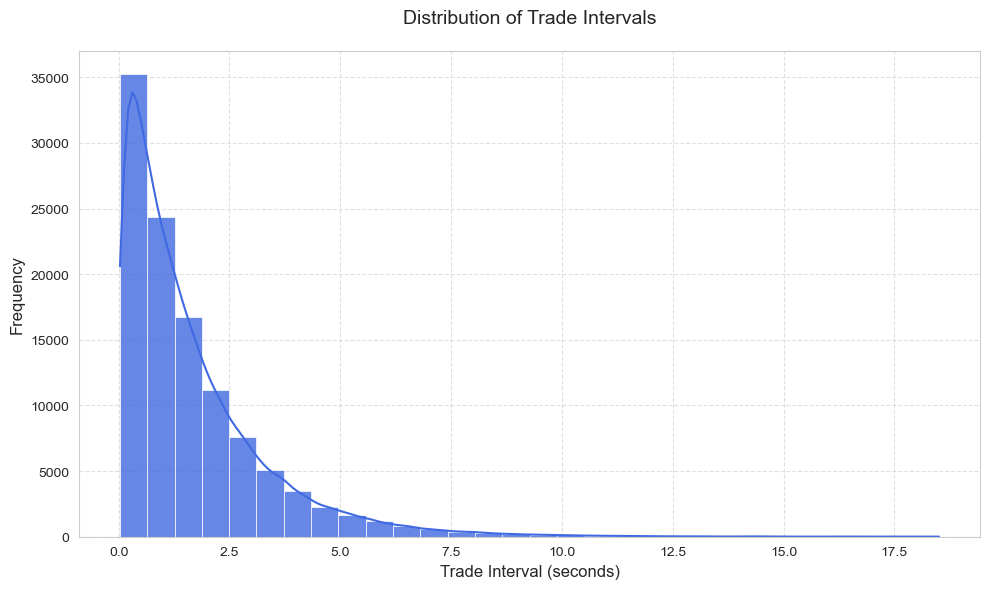

In [152]:
plot_trade_duration(main_df1['trade_duration'])

In [153]:
main_df1['trade_duration'].describe()

count   111509.000
mean         1.646
std          1.657
min          0.031
25%          0.496
50%          1.147
75%          2.263
max         18.507
Name: trade_duration, dtype: float64

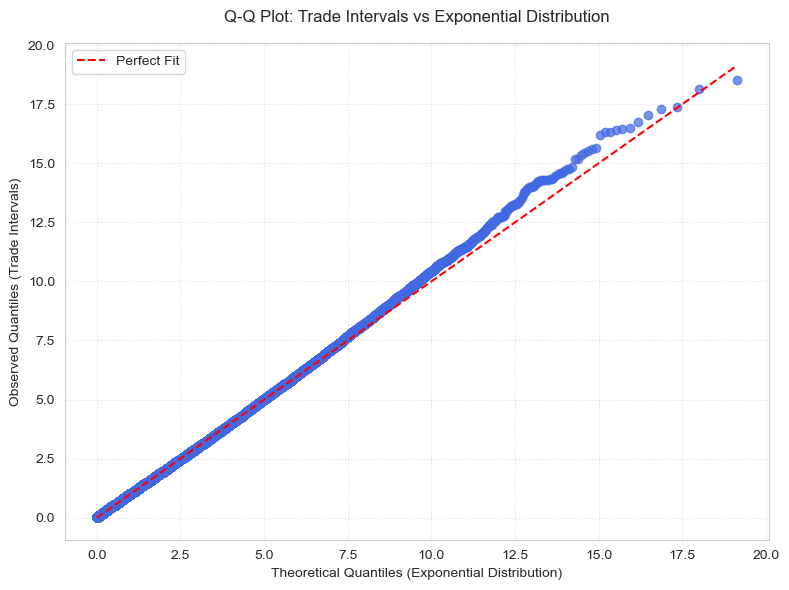

In [154]:
plot_exponential_qq(main_df1['trade_duration'])

Quantiles of inter-event durations compared with quantiles of an exponential distribution with the same mean. The dashed line represents the perfect fit line exponential distribution fitted to the observed durations. Observed durations are found to be quite similar till the 11 sec mark, after which points representing the trade events that take too long >10s are talking longer than what it take in a true exponantial distribution. Looking at the first graph, such trades are rare. Knowing that the exponential distribution is a good fit for the inter-event durations, we can use it to model the time between trades. This can be useful for predicting future trade events and also simulating trade events in a market model. Knowing that trades are following Poisson process for the most part, indicates that in this case trades show a memoryless property, meaning that the time until the next trade does not depend on how long it has been since the last trade. This open up possibiliites like time-weighted average price (TWAP) strategies, where traders can place orders at regular intervals to achieve a desired average price over a specified time period. Also if inter-event duration deviates significantly from the exponential distribution, it may indicate a useful signal for trading strategies, such as identifying periods of increased market activity or potential price movements. I also see possibilities of using time-based models like ACD (Autoregressive Conditional Duration) models as strong baseline to capture the dynamics of inter-event durations and improve trading strategies based on the observed patterns in the data.

In [155]:
main_df1['burst_flag'] = main_df1['trade_duration'] > 5
print(f"Fraction of inter-trade intervals > 3 sec: {main_df1['burst_flag'].mean():.2%}")

Fraction of inter-trade intervals > 3 sec: 4.81%


In [156]:
main_df1['long_idle_cluster'] = (main_df1['burst_flag'] & main_df1['burst_flag'].shift(1) & main_df1['burst_flag'].shift(-1))

In [157]:
main_df1['long_idle_cluster'].sum()

43

In [158]:
main_df1.head()

,datetime,vol,price,mid_price,spread,trade_duration,burst_flag,long_idle_cluster
1,2026-01-09 08:00:08.773,5.000,195.500,197.000,2.000,0.744,False,False
2,2026-01-09 08:00:15.190,1.000,194.000,193.000,2.000,6.417,True,False
3,2026-01-09 08:00:17.329,3.000,192.000,192.500,1.000,2.139,False,False
4,2026-01-09 08:00:17.360,4.000,192.000,193.500,3.000,0.031,False,False
5,2026-01-09 08:00:20.615,1.000,196.000,194.000,4.000,3.255,False,False


In [159]:
main_df1.groupby(main_df1['datetime'].dt.date)['long_idle_cluster'].sum()

datetime
2026-01-09     2
2026-02-10    36
2026-03-10     3
2026-04-10     0
2026-05-11     0
2026-06-10     2
Name: long_idle_cluster, dtype: int64

In [160]:
main_df.head()

,timestamp,date,datetime,bid,ask,price,vol,mid_price,spread
0,2.573,2026-01-09,2026-01-09 08:00:02.573,"[[156, 2]]","[[199, 1]]",0.000,0.000,177.500,43
1,2.666,2026-01-09,2026-01-09 08:00:02.666,"[[186, 1], [156, 2]]","[[199, 1]]",0.000,0.000,192.500,13
2,3.782,2026-01-09,2026-01-09 08:00:03.782,"[[186, 1], [161, 2]]","[[199, 1]]",0.000,0.000,192.500,13
3,3.906,2026-01-09,2026-01-09 08:00:03.906,"[[186, 1], [181, 5], [161, 2]]","[[199, 1]]",0.000,0.000,192.500,13
4,4.464,2026-01-09,2026-01-09 08:00:04.464,"[[187, 4], [186, 1], [181, 5], [161, 2]]","[[199, 1]]",0.000,0.000,193.000,12


In [161]:
# start = pd.to_datetime('2026-02-10 15:30:00')
# cutoff = pd.to_datetime('2026-02-10 16:30:00')
# mask =  (main_df1['datetime'] >= start) & (main_df1['datetime'] <= cutoff)
# plot_burst_events(main_df1.loc[mask])

In [162]:
# reload_custom_modules()

In [163]:
main_df1 = calculate_forward_returns(main_df1, price_col='mid_price', periods=10, remove_outliers=True, duration_percentile=0.99)

In [164]:
# # Calculate mid-price returns 10 periods ahead
# main_df1['mid_return_10'] = main_df1['mid_price'].pct_change(periods=10).shift(-10)
# # Remove rows with NaN in 'trade_duration' or 'mid_return_10'
# main_df1 = main_df1.dropna(subset=['trade_duration', 'mid_return_10'])
# # Remove outliers in trade duration
# main_df1 = main_df1[main_df1['trade_duration'] < main_df1['trade_duration'].quantile(0.99)]

In [165]:
main_df1.head()

,datetime,vol,price,mid_price,spread,trade_duration,burst_flag,long_idle_cluster,mid_price_return_10
1,2026-01-09 08:00:08.773,5.000,195.500,197.000,2.000,0.744,False,False,-0.071
2,2026-01-09 08:00:15.190,1.000,194.000,193.000,2.000,6.417,True,False,-0.039
3,2026-01-09 08:00:17.329,3.000,192.000,192.500,1.000,2.139,False,False,-0.034
4,2026-01-09 08:00:17.360,4.000,192.000,193.500,3.000,0.031,False,False,-0.052
5,2026-01-09 08:00:20.615,1.000,196.000,194.000,4.000,3.255,False,False,-0.031


In [183]:
main_df1.dtypes

datetime                    datetime64[ns]
vol                                float64
price                              float64
mid_price                          float64
spread                             float64
trade_duration                     float64
burst_flag                            bool
long_idle_cluster                     bool
mid_price_return_10                float64
log_trade_duration_bin            category
trade_duration_bin_label          category
dtype: object

In [ ]:
main_df1, bin_stats = create_quantile_bins(main_df1, value_col='trade_duration', analysis_col='mid_price_return_10', num_bins=15, use_log_scale=True)

In [167]:
main_df1.head()

,datetime,vol,price,mid_price,spread,trade_duration,burst_flag,long_idle_cluster,mid_price_return_10,log_trade_duration_bin,trade_duration_bin_label
1,2026-01-09 08:00:08.773,5.000,195.500,197.000,2.000,0.744,False,False,-0.071,"(0.52, 0.608]",0.68–0.84
2,2026-01-09 08:00:15.190,1.000,194.000,193.000,2.000,6.417,True,False,-0.039,"(1.652, 2.173]",4.22–7.78
3,2026-01-09 08:00:17.329,3.000,192.000,192.500,1.000,2.139,False,False,-0.034,"(1.134, 1.265]",2.11–2.54
4,2026-01-09 08:00:17.360,4.000,192.000,193.500,3.000,0.031,False,False,-0.052,"(0.0295, 0.117]",0.03–0.12
5,2026-01-09 08:00:20.615,1.000,196.000,194.000,4.000,3.255,False,False,-0.031,"(1.426, 1.652]",3.16–4.22


In [168]:
bin_stats

,mean,count,std
trade_duration_bin_label,,,
0.03–0.12,0.100,7995,0.510
0.12–0.25,0.096,7507,0.505
0.25–0.37,0.101,7036,0.510
0.37–0.53,0.105,8156,0.516
0.53–0.68,0.090,7444,0.505
0.68–0.84,0.080,6709,0.477
0.84–1.02,0.095,7204,0.508
1.02–1.24,0.079,7575,0.481
1.24–1.49,0.091,7441,0.502


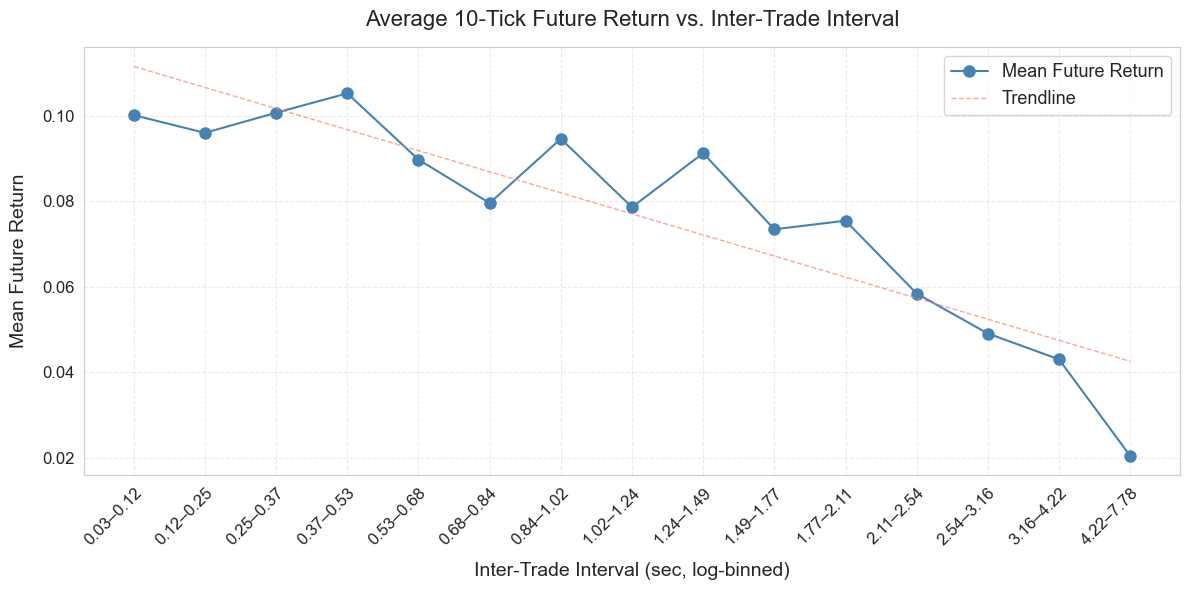

<Axes: title={'center': 'Average 10-Tick Future Return vs. Inter-Trade Interval'}, xlabel='Inter-Trade Interval (sec, log-binned)', ylabel='Mean Future Return'>

In [177]:
plot_binned_stats(bin_stats.index, bin_stats['mean'], y_errors=bin_stats['std'],
                  counts=bin_stats['count'],
                  title="Average 10-Tick Future Return vs. Inter-Trade Interval",
                  x_label="Inter-Trade Interval (sec, log-binned)",
                  y_label="Mean Future Return",
                  tilt_x_ticks=True,
                  add_trendline=True,
                  )

Plot indicates as inter-trade intervals get longer (i.e., market activity slows), the mean future return tends to decline. This is intuitive, as longer intervals may indicate reduced trading activity or liquidity, leading to less price movement. This relationship can be useful for traders to understand how market conditions change over time and adjust their strategies accordingly. Bin_stats also shows that the mean future return is more volatile at shorter inter-trade intervals, which could indicate that rapid trading activity leads to more unpredictable price movements. All bins are positive, indicating price move up more frequently when there is activity, though we are using mid-price returns here, which tend to smooth things a bit.

In [197]:
df_tmp = count_trades_by_time_bin(main_df1)

In [198]:
df_tmp

,time_bin,trade_count
0,2026-01-09 08:00:00,1040
1,2026-01-09 08:30:00,1101
2,2026-01-09 09:00:00,1266
3,2026-01-09 09:30:00,1217
4,2026-01-09 10:00:00,1054
...,...,...
97,2026-06-10 14:00:00,1215
98,2026-06-10 14:30:00,1208
99,2026-06-10 15:00:00,1081
100,2026-06-10 15:30:00,1268


In [195]:
df_tmp.columns

Index(['trade_count'], dtype='object')

In [201]:
df_tmp2 = calculate_time_based_stats(df_tmp, datetime_col='time_bin', value_col='trade_count')

In [212]:
df_tmp2

,trade_count
time,
08:00:00,975.833
08:30:00,1076.500
09:00:00,1166.333
09:30:00,1101.000
10:00:00,1116.500
10:30:00,1067.667
11:00:00,1130.667
11:30:00,1101.167
12:00:00,1126.833


In [223]:
df_tmp2.reset_index()

,time,trade_count
0,08:00:00,975.833
1,08:30:00,1076.500
2,09:00:00,1166.333
3,09:30:00,1101.000
4,10:00:00,1116.500
5,10:30:00,1067.667
6,11:00:00,1130.667
7,11:30:00,1101.167
8,12:00:00,1126.833
9,12:30:00,1092.000


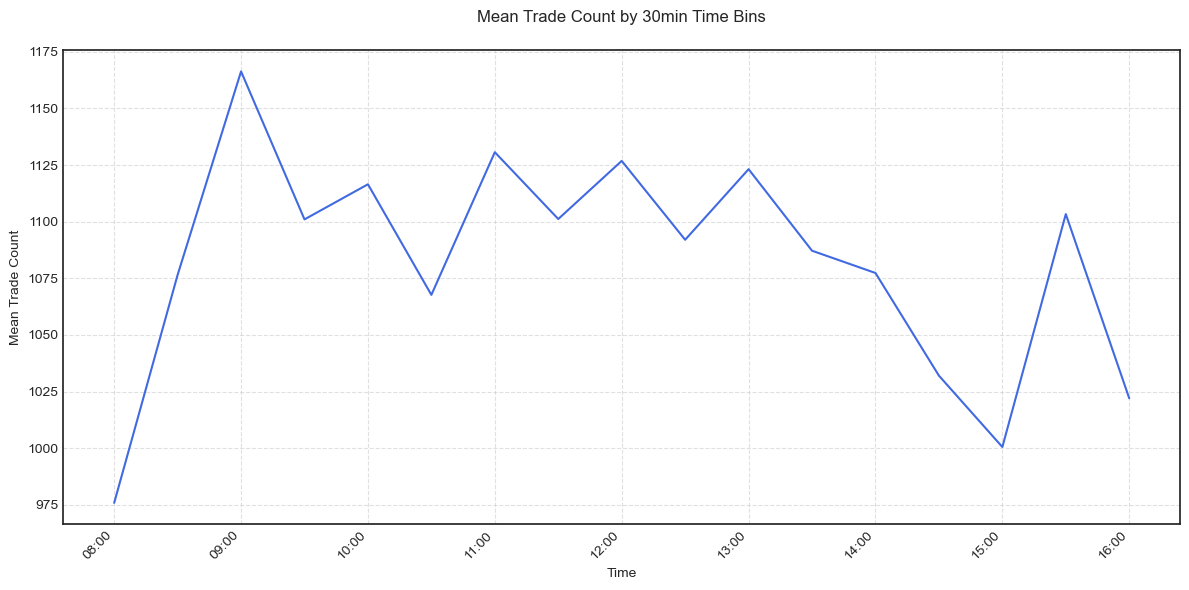

In [224]:
plot_time_series(df_tmp2.reset_index(), value_col='trade_count', title='Mean Trade Count by 30min Time Bins', ylabel='Mean Trade Count')

Generally trading activity starts slowly and picks up as the market opens, with a peak around 9 AM. After that, activity tends to decline throughout the day, with a notable drop in the second last hour of trading and small peak 30mins before the close of the day. 